<a href="https://colab.research.google.com/github/zerweck/dscommunity-hackathon/blob/hackathon1/hackathon_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Setup Environment

In [44]:
%cd /content

!if cd dscommunity-hackathon; then git pull; else git clone --branch hackathon1 https://github.com/zerweck/dscommunity-hackathon; fi

%cd /content/dscommunity-hackathon

/content
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/zerweck/dscommunity-hackathon
   3c88c92..62267dc  hackathon1 -> origin/hackathon1
Updating 3c88c92..62267dc
Fast-forward
 .../electricity/hourly_electricity_predicted_small.7z | Bin 0 -> 1349210 bytes
 .../hourly_electricity_typeday_predicted.7z           | Bin 2600040 -> 0 bytes
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 out/saved_models/electricity/hourly_electricity_predicted_small.7z
 delete mode 100644 out/saved_models/electricity/hourly_electricity_typeday_predicted.7z
/content/dscommunity-hackathon


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 81kB 4.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=09a4e88f72be186c6582566b5f51cac63f0ddeaf2efb6a9a68845665b6c3be0c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [31]:
import matplotlib.pyplot as plt

# Optional: Only if you want zoomable plots
!pip install mpld3
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

## Download Data

In [4]:
from script_download_data import *
import expt_settings.configs

expt_name = 'electricity' # ['volatility', 'traffic', 'favorita']
folder = 'out'
# init data read
main(expt_name, True, folder)

#### Running download script ###
Resetting data folder...
Getting electricity data...
Pulling data from https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip to out/data/electricity/LD2011_2014.txt.zip
done
Unzipping file: out/data/electricity/LD2011_2014.txt.zip
Done.
Aggregating to hourly data
Processing MT_001
Processing MT_002
Processing MT_003
Processing MT_004
Processing MT_005
Processing MT_006
Processing MT_007
Processing MT_008
Processing MT_009
Processing MT_010
Processing MT_011
Processing MT_012
Processing MT_013
Processing MT_014
Processing MT_015
Processing MT_016
Processing MT_017
Processing MT_018
Processing MT_019
Processing MT_020
Processing MT_021
Processing MT_022
Processing MT_023
Processing MT_024
Processing MT_025
Processing MT_026
Processing MT_027
Processing MT_028
Processing MT_029
Processing MT_030
Processing MT_031
Processing MT_032
Processing MT_033
Processing MT_034
Processing MT_035
Processing MT_036
Processing MT_037
Process

## Format Data

In [5]:
from data_formatters.electricity import ElectricityFormatter
from data_formatters.base import DataTypes, InputTypes
class CustomElectricityFormatter(ElectricityFormatter):
  """Defines and formats data for the electricity dataset. Modified for extra features support 

  Note that per-entity z-score normalization is used here, and is implemented
  across functions.
  """
  _column_definition = [
      ('id', DataTypes.REAL_VALUED, InputTypes.ID),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
      ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
      ('power_usage_lag24', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag48', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag72', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag168', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
  ]
  def split_data(self, df, valid_boundary=1315, test_boundary=1339):
    """Splits data frame into training-validation-test data frames.
    This also calibrates scaling object, and transforms data for each split.
    Args:
      df: Source data frame to split.
      valid_boundary: Starting year for validation data
      test_boundary: Starting year for test data
    Returns:
      Tuple of transformed (train, valid, test) data.
    """

    print('Formatting train-valid-test splits.')

    index = df['days_from_start']
    train = df.loc[index < valid_boundary]
    valid = df.loc[(index >= valid_boundary ) & (index < test_boundary)]
    test = df.loc[index >= test_boundary ]

    self.set_scalers(train)

    return (self.transform_inputs(data) for data in [train, valid, test])
def build_lags(data, col='power_usage', id_col='id', lags=[24, 48, 72, 168]):
    for i in lags:
      col_lag = "{}_lag{}".format(col, i)
      data[col_lag] = data.groupby(id_col)[col].shift(i)
    return data


In [6]:
# make experiment config
ExperimentConfig = expt_settings.configs.ExperimentConfig
config = ExperimentConfig(expt_name, folder)

#prepare data formatter 
# data_formatter = config.make_data_formatter()
# for current experiment use a custom defined formatter with extra features and 
# data splits
data_formatter = CustomElectricityFormatter()
data_csv_path = config.data_csv_path

print("Loading & splitting data...")
data = pd.read_csv(data_csv_path, index_col=0)
data_w_lags = build_lags(data.copy())

# Pre-given Data Split
train, valid, test = data_formatter.split_data(data_w_lags.dropna())

Loading & splitting data...


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [19]:
# Export Train + Test for typeDay Model (not in Notebook)
# import feather
# feather.write_dataframe(train[['id','hour','date','power_usage']], 'out/data/electricity/train.feather')
# feather.write_dataframe(test[['id','hour','date','power_usage']], 'out/data/electricity/test.feather')

## Describe Data

### Preprocessed Data

In [7]:
train

power_usage        t  ...  power_usage_lag72  power_usage_lag168
168         -0.022173   8928.0  ...           0.401375           -0.341579
169         -0.075490   8929.0  ...           1.519362           -0.181285
170         -0.075490   8930.0  ...           0.188425           -0.074422
171         -0.128807   8931.0  ...           2.104974           -0.127854
172         -0.075490   8932.0  ...           2.158211           -0.074422
...               ...      ...  ...                ...                 ...
10460738     0.294541  31555.0  ...           1.924594            2.119849
10460739     0.106370  31556.0  ...           1.924594            1.880292
10460740    -0.266612  31557.0  ...           1.406780            2.093232
10460741     0.015645  31558.0  ...           1.266469            1.268089
10460742    -0.659756  31559.0  ...           1.206336            1.158292

[9109068 rows x 17 columns]

In [20]:
print('Train Set Time Range')
print(train.agg({"date": [np.min, np.max]}))
print('\nValidation Set Time Range')
print(valid.agg({"date": [np.min, np.max]}))
print('\nTest Set Time Range')
print(test.agg({"date": [np.min, np.max]}))

Train Set Time Range
                     date
amin  2011-01-08 00:00:00
amax  2014-08-07 23:00:00

Validation Set Time Range
                     date
amin  2014-08-08 00:00:00
amax  2014-08-31 23:00:00

Test Set Time Range
                     date
amin  2014-09-01 00:00:00
amax  2015-01-01 00:00:00


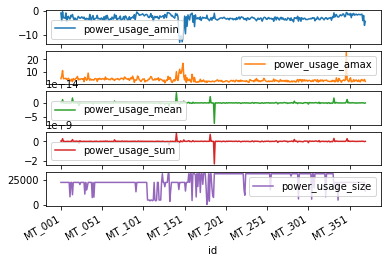

In [33]:
# Plot power_usage by User ID
train_agg_by_id = train.groupby("id").agg({"power_usage": [np.min, np.max, np.mean, np.sum, np.size]})
train_agg_by_id.columns = ["_".join(a) for a in train_agg_by_id.columns.to_flat_index()]
# train_agg_by_id['id2'] = train_agg_by_id.index
# train_agg_by_id.columns

# for colname in [c for c in train_agg_by_id.columns if c != "id2"]:
#   train_agg_by_id.plot(x="id2", y=colname)
_ = train_agg_by_id.plot(subplots="True")

### Plot Data

power_usage    1.284026e-15
dtype: float64

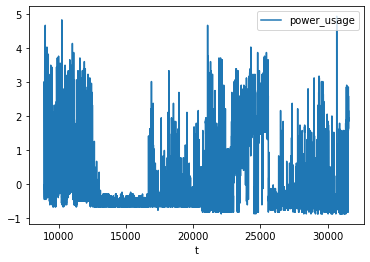

In [34]:
train.loc[train.id =='MT_001', ['t', 'power_usage']].plot(x = 't', y = 'power_usage')
train.loc[train.id =='MT_001', ['power_usage']].mean()

# Baseline Modeling 1: LightGBM

## Setup LGBM

In [35]:
import lightgbm as lgb

# Hardcode feature names
FEATURE_NAMES = ['categorical_id', 'hours_from_start', 'categorical_day_of_week', 'categorical_hour',
                               'power_usage_lag24', 'power_usage_lag48', 'power_usage_lag72', 'power_usage_lag168']
CAT_NAMES = ['categorical_id', 'categorical_day_of_week', 'categorical_hour']

# construct lgb datasets
train_data = lgb.Dataset(train[FEATURE_NAMES], 
                         label=train[['power_usage']], 
                         feature_name=FEATURE_NAMES, 
                         categorical_feature=CAT_NAMES)

val_data = lgb.Dataset(valid[FEATURE_NAMES], 
                       label=valid[['power_usage']], 
                         feature_name=FEATURE_NAMES, 
                         categorical_feature=CAT_NAMES)

valid[FEATURE_NAMES].dtypes


categorical_id               int64
hours_from_start           float64
categorical_day_of_week      int64
categorical_hour             int64
power_usage_lag24          float64
power_usage_lag48          float64
power_usage_lag72          float64
power_usage_lag168         float64
dtype: object

## Define hyperparameters

In [37]:
num_round = 2000
param = {'num_leaves': 31, 'objective': 'regression', "learning_rate":0.01, "num_threads":6}

## Train Model

In [51]:
retrain_lgbm = True #@param {type:"boolean"}

In [ ]:
if retrain_lgbm:
  # Retrain and save model
  fit = lgb.train(param, train_data, num_round, valid_sets=[val_data])
  fit.save_model('out/saved_models/electricity/my_lgbm_trained.booster')
else:
  # Load pre-trained model from repository
  fit = lgb.Booster(model_file='out/saved_models/electricity/lgbm_trained.booster')


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 1.08067
[2]	valid_0's l2: 1.06212
[3]	valid_0's l2: 1.04398
[4]	valid_0's l2: 1.0262
[5]	valid_0's l2: 1.00876
[6]	valid_0's l2: 0.991657
[7]	valid_0's l2: 0.974897
[8]	valid_0's l2: 0.95846
[9]	valid_0's l2: 0.94234
[10]	valid_0's l2: 0.92653
[11]	valid_0's l2: 0.911067
[12]	valid_0's l2: 0.895871
[13]	valid_0's l2: 0.880967
[14]	valid_0's l2: 0.866355
[15]	valid_0's l2: 0.851996
[16]	valid_0's l2: 0.83793
[17]	valid_0's l2: 0.824175
[18]	valid_0's l2: 0.810682
[19]	valid_0's l2: 0.797453
[20]	valid_0's l2: 0.784478
[21]	valid_0's l2: 0.771711
[22]	valid_0's l2: 0.759219
[23]	valid_0's l2: 0.746996
[24]	valid_0's l2: 0.734992
[25]	valid_0's l2: 0.72323
[26]	valid_0's l2: 0.71169
[27]	valid_0's l2: 0.700403
[28]	valid_0's l2: 0.68932
[29]	valid_0's l2: 0.678431
[30]	valid_0's l2: 0.66775
[31]	valid_0's l2: 0.65729
[32]	valid_0's l2: 0.647027
[33]	valid_0's l2: 0.636992
[34]	valid_0's l2: 0.627137
[35]	valid_0's l2: 0.617488
[36]	valid_0's l2: 0.608002
[37]	valid_0's l

## Predict Testset

In [40]:
lgbm_pred = fit.predict(test[FEATURE_NAMES])

test['lgbmPred'] = lgbm_pred
test['lgbmPred']

23376      -0.074448
23377      -0.392751
23378      -0.373557
23379      -0.375421
23380      -0.362283
              ...   
10464243   -1.714885
10464244   -1.820841
10464245   -1.843988
10464246   -1.572096
10464247   -1.195126
Name: lgbmPred, Length: 1080476, dtype: float64

### Test Set Prediction Results

In [41]:
np.sqrt(np.mean((test.power_usage - lgbm_pred)**2))

1.39535145246075

### Plot Predictions

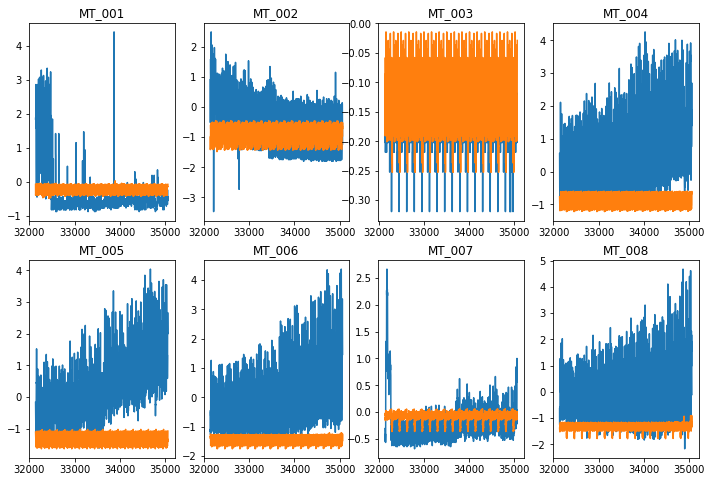

In [42]:
# some plots
nrow = 4

fig, ax = plt.subplots(2, nrow, figsize=(12,8), facecolor='w', edgecolor='k')
ids = np.unique(test.id)[:8]
for i in range(8):
    ax[i//nrow,i%nrow].plot(test.loc[test.id == ids[i], 't'], test.loc[test.id == ids[i], 'power_usage'])
    ax[i//nrow,i%nrow].plot(test.loc[test.id == ids[i], 't'], lgbm_pred[test.id == ids[i]])
    ax[i//nrow,i%nrow].set_title(ids[i])


#plt.plot(test.t, lgbm_pred)


### Feature Importance
Default Importance metric: Splits = How often was this Feature used in a split in all trees

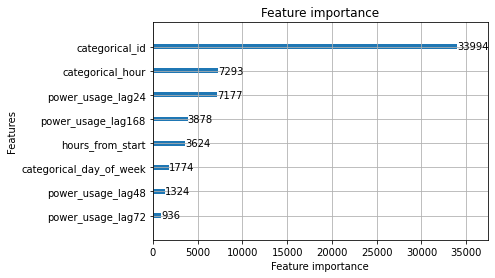

In [43]:
lgb.plot_importance(fit)

# Baseline Modeling 0: Typeday Prediction

In [45]:
# Unpack
pyunpack.Archive('out/saved_models/electricity/hourly_electricity_predicted_small.7z').extractall('out/saved_models/electricity')
# Read in
typeday_predicted = pd.read_csv('out/saved_models/electricity/hourly_electricity_predicted_small.csv')

In [46]:
typeday_predicted = typeday_predicted[~typeday_predicted.typeDayPred.isnull()].reset_index()

In [47]:
# Join Typeday Prediction with testset
test.date = pd.to_datetime(test.date, utc = True)
typeday_predicted.date = pd.to_datetime(typeday_predicted.date, utc = True)

test_pred = pd.merge(test[['id','date','power_usage', 'lgbmPred']],typeday_predicted,on=['id', 'date'],how="left")

test_pred

id                      date  ...    index  typeDayPred
0        MT_001 2014-09-01 00:00:00+00:00  ...        0     0.279957
1        MT_001 2014-09-01 01:00:00+00:00  ...        1     0.262184
2        MT_001 2014-09-01 02:00:00+00:00  ...        2     0.244412
3        MT_001 2014-09-01 03:00:00+00:00  ...        3     0.262184
4        MT_001 2014-09-01 04:00:00+00:00  ...        4     0.279957
...         ...                       ...  ...      ...          ...
1080471  MT_370 2014-12-31 20:00:00+00:00  ...  1080471     1.280200
1080472  MT_370 2014-12-31 21:00:00+00:00  ...  1080472     1.367565
1080473  MT_370 2014-12-31 22:00:00+00:00  ...  1080473     1.167073
1080474  MT_370 2014-12-31 23:00:00+00:00  ...  1080474     1.144672
1080475  MT_370 2015-01-01 00:00:00+00:00  ...  1080475     1.346284

[1080476 rows x 6 columns]

In [48]:
np.sqrt(np.mean((test_pred.power_usage - test_pred.typeDayPred)**2))

0.7808368666842321